# LNG Spot Price Dynamics

## Table of Contents

### Research Question / The Problem
- [What Drives LNG Spot Prices?](#problem)

### Data Quality Check
- [Simple Inspection of Data](#dataquality)

### Exploratory Data Analysis
- [Descriptive Statistics](#descriptivestats)

### Methodology
- [Augmented Dickey-Fuller Unit Root Test](#adf)
- [Engle-Granger and Johansen Cointegration Tests](#egj)
- [Granger Causality Tests](#granger)
- [Error Correction Model](#ecm)

### Conclusion
- [Reflections](#results)

<a id='problem'></a>
## Research Question / The Problem

Given the fact that long-term LNG contracts are linked to oil and/or hub-based pricing, an interesting question is which determinants drive spot prices in the global LNG markets. 

This study employs weekly time-series data to analyze these price dynamics in the largest LNG market in the world (Japan), largest LNG trading hub in Europe (U.K.), and in the world’s largest LNG re-exporting hub (Spain) between 2010 and 2015.
***

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
# to hide warning messages
import warnings
warnings.filterwarnings('ignore')

### Read the Data

In [143]:
# Read the 'Main' sheet into a DataFrame
lngdata = pd.read_excel('LNGData.xlsx', sheet_name='Main', skiprows=1)

# Display the first few rows of the DataFrame to verify the data
lngdata.head()

,Date,NBP_spot ($/MMBtu),Barcelona_spot ($/MMBtu),Japan_spot ($/MMBtu),Henry Hub ($/MMBtu),NWE_contract ($/MMBtu),Japan_contract ($/MMBtu),Atlantic_charter ($/day),Pacific_charter ($/day),Storage_amount (MMcm),...,Barcelona_cdd,Barcelona_hdd,Tokyo_cdd,Tokyo_hdd,Japan_ip,UK_ip,Spain_ip,Japan_cm,UK_cm,Spain_cm
0,2010-01-08,5.84,5.80,7.5,6.56,8.29,9.74,49000.0,49000.0,57153.0,...,0,19,0,21,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-15,5.52,5.50,7.8,5.68,8.37,9.74,48000.0,48000.0,NaN,...,0,19,0,25,88.8,90.55,94.22,97.3,98.46,90.58
2,2010-01-22,5.55,5.20,7.6,5.56,8.23,9.74,45000.0,45000.0,49978.0,...,0,14,0,19,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-29,6.65,6.50,7.2,5.47,8.23,9.90,44000.0,44000.0,46953.0,...,0,18,0,18,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-02-05,5.75,5.75,7.3,5.47,9.11,9.90,42000.0,42000.0,43262.0,...,0,17,0,25,NaN,NaN,NaN,NaN,NaN,NaN


In [144]:
# Rename certain columns for better readability
lngdata = lngdata.rename(columns={'NBP_spot ($/MMBtu)': 'nbp', 
                        'Barcelona_spot ($/MMBtu)': 'spain_sp',
                        'Japan_spot ($/MMBtu)': 'japan_sp',
                        'Henry Hub ($/MMBtu)': 'hh',
                        'NWE_contract ($/MMBtu)': 'nwe_con',
                        'Japan_contract ($/MMBtu)': 'japan_con',
                        'Atlantic_charter ($/day)': 'atl_cha',
                        'Pacific_charter ($/day)' : 'pac_cha',
                        'Storage_amount (MMcm)' : 'sto_amo',
                        'Storage_capacity (MMcm)': 'sto_cap',
                        'Storage_ratio (%)': 'sto_rat',
                        'Brent_crude ($/barrel)': 'brent',
                        'JCC ($/barrel)': 'jcc',
                        'Qinhuangdao_coal ($/MMBtu)': 'qin_coal',
                        'ARA_coal ($/MMBtu)': 'ara_coal',
                        'London_cdd': 'london_cdd',
                        'London_hdd': 'london_hdd',
                        'Barcelona_cdd': 'barca_cdd',
                        'Barcelona_hdd': 'barca_hdd',
                        'Tokyo_cdd': 'tokyo_cdd',
                        'Tokyo_hdd': 'tokyo_hdd',
                        'Japan_ip': 'japan_ip',
                        'UK_ip': 'uk_ip',
                        'Spain_ip': 'spain_ip',
                        'Japan_cm': 'japan_cm',
                        'UK_cm': 'uk_cm',
                        'Spain_cm': 'spain_cm'
                        })

lngdata.head()

,Date,nbp,spain_sp,japan_sp,hh,nwe_con,japan_con,atl_cha,pac_cha,sto_amo,...,barca_cdd,barca_hdd,tokyo_cdd,tokyo_hdd,japan_ip,uk_ip,spain_ip,japan_cm,uk_cm,spain_cm
0,2010-01-08,5.84,5.80,7.5,6.56,8.29,9.74,49000.0,49000.0,57153.0,...,0,19,0,21,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-15,5.52,5.50,7.8,5.68,8.37,9.74,48000.0,48000.0,NaN,...,0,19,0,25,88.8,90.55,94.22,97.3,98.46,90.58
2,2010-01-22,5.55,5.20,7.6,5.56,8.23,9.74,45000.0,45000.0,49978.0,...,0,14,0,19,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-29,6.65,6.50,7.2,5.47,8.23,9.90,44000.0,44000.0,46953.0,...,0,18,0,18,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-02-05,5.75,5.75,7.3,5.47,9.11,9.90,42000.0,42000.0,43262.0,...,0,17,0,25,NaN,NaN,NaN,NaN,NaN,NaN


<a id='dataquality'></a>
## Data Quality Check

In [145]:
lngdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        304 non-null    datetime64[ns]
 1   nbp         280 non-null    float64       
 2   spain_sp    280 non-null    float64       
 3   japan_sp    280 non-null    float64       
 4   hh          293 non-null    float64       
 5   nwe_con     280 non-null    float64       
 6   japan_con   280 non-null    float64       
 7   atl_cha     284 non-null    float64       
 8   pac_cha     284 non-null    float64       
 9   sto_amo     297 non-null    float64       
 10  sto_cap     297 non-null    float64       
 11  sto_rat     299 non-null    float64       
 12  brent       304 non-null    float64       
 13  jcc         69 non-null     float64       
 14  qin_coal    304 non-null    float64       
 15  ara_coal    304 non-null    float64       
 16  london_cdd  304 non-null  

In [146]:
# Check the type of our features. Are there any data inconsistencies?
lngdata.dtypes

Date          datetime64[ns]
nbp                  float64
spain_sp             float64
japan_sp             float64
hh                   float64
nwe_con              float64
japan_con            float64
atl_cha              float64
pac_cha              float64
sto_amo              float64
sto_cap              float64
sto_rat              float64
brent                float64
jcc                  float64
qin_coal             float64
ara_coal             float64
london_cdd             int64
london_hdd             int64
barca_cdd              int64
barca_hdd              int64
tokyo_cdd              int64
tokyo_hdd              int64
japan_ip             float64
uk_ip                float64
spain_ip             float64
japan_cm             float64
uk_cm                float64
spain_cm             float64
dtype: object

In [147]:
# Check in which columns I have any missing / null values
lngdata.isnull().any()

Date          False
nbp            True
spain_sp       True
japan_sp       True
hh             True
nwe_con        True
japan_con      True
atl_cha        True
pac_cha        True
sto_amo        True
sto_cap        True
sto_rat        True
brent         False
jcc            True
qin_coal      False
ara_coal      False
london_cdd    False
london_hdd    False
barca_cdd     False
barca_hdd     False
tokyo_cdd     False
tokyo_hdd     False
japan_ip       True
uk_ip          True
spain_ip       True
japan_cm       True
uk_cm          True
spain_cm       True
dtype: bool

I have NaNs in my data series because energy information data providers and government agencies do not report data on holidays. Additionally, certain data, such as industrial production indices, is reported on a monthly basis. To make the most of my dataset, I will apply linear interpolation to fill in these missing values.

In [148]:
# List of columns to interpolate
columns_to_interpolate = ['nbp', 'spain_sp', 'japan_sp', 'hh', 'nwe_con', 'japan_con', 'atl_cha', 'pac_cha', 
                          'sto_amo', 'sto_cap', 'sto_rat', 'jcc', 'japan_ip', 'uk_ip', 'spain_ip', 'japan_cm', 
                         'uk_cm', 'spain_cm']

# Apply linear interpolation to fill missing values in the specified columns
lngdata[columns_to_interpolate] = lngdata[columns_to_interpolate].interpolate(method='linear')

lngdata.head()

,Date,nbp,spain_sp,japan_sp,hh,nwe_con,japan_con,atl_cha,pac_cha,sto_amo,...,barca_cdd,barca_hdd,tokyo_cdd,tokyo_hdd,japan_ip,uk_ip,spain_ip,japan_cm,uk_cm,spain_cm
0,2010-01-08,5.84,5.80,7.5,6.56,8.29,9.74,49000.0,49000.0,57153.0,...,0,19,0,21,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-15,5.52,5.50,7.8,5.68,8.37,9.74,48000.0,48000.0,53565.5,...,0,19,0,25,88.800,90.550,94.22,97.30,98.4600,90.58
2,2010-01-22,5.55,5.20,7.6,5.56,8.23,9.74,45000.0,45000.0,49978.0,...,0,14,0,19,90.275,90.955,94.99,97.05,99.2925,91.76
3,2010-01-29,6.65,6.50,7.2,5.47,8.23,9.90,44000.0,44000.0,46953.0,...,0,18,0,18,91.750,91.360,95.76,96.80,100.1250,92.94
4,2010-02-05,5.75,5.75,7.3,5.47,9.11,9.90,42000.0,42000.0,43262.0,...,0,17,0,25,93.225,91.765,96.53,96.55,100.9575,94.12


In [149]:
lngdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        304 non-null    datetime64[ns]
 1   nbp         304 non-null    float64       
 2   spain_sp    304 non-null    float64       
 3   japan_sp    304 non-null    float64       
 4   hh          304 non-null    float64       
 5   nwe_con     304 non-null    float64       
 6   japan_con   304 non-null    float64       
 7   atl_cha     304 non-null    float64       
 8   pac_cha     304 non-null    float64       
 9   sto_amo     304 non-null    float64       
 10  sto_cap     304 non-null    float64       
 11  sto_rat     304 non-null    float64       
 12  brent       304 non-null    float64       
 13  jcc         302 non-null    float64       
 14  qin_coal    304 non-null    float64       
 15  ara_coal    304 non-null    float64       
 16  london_cdd  304 non-null  

To have full data for industrial and chemical production indices, I replace the only NaN with the following week's observation.

In [150]:
# List of columns to fill NaN values in the first row
columns_to_fill = ['japan_ip', 'uk_ip', 'spain_ip', 'japan_cm', 'uk_cm', 'spain_cm']

# Loop through each column and fill NaN values in the first row with values from the second row
for column in columns_to_fill:
    lngdata[column].fillna(lngdata.iloc[1][column], inplace=True)

# Print the updated DataFrame
print(lngdata[columns_to_fill].head())

   japan_ip   uk_ip  spain_ip  japan_cm     uk_cm  spain_cm
0    88.800  90.550     94.22     97.30   98.4600     90.58
1    88.800  90.550     94.22     97.30   98.4600     90.58
2    90.275  90.955     94.99     97.05   99.2925     91.76
3    91.750  91.360     95.76     96.80  100.1250     92.94
4    93.225  91.765     96.53     96.55  100.9575     94.12


With that problem fixed, now we can begin our exploratory data analysis.

<a id='descriptivestats'></a>
## Exploratory Data Analysis
***

In [151]:
# Check the dimensions (# of columns vs. # of rows) of my data set
lngdata.shape

(304, 28)

In [152]:
# Display the statistical overview of the prices and other data series
lngdata.describe().round(2)

,nbp,spain_sp,japan_sp,hh,nwe_con,japan_con,atl_cha,pac_cha,sto_amo,sto_cap,...,barca_cdd,barca_hdd,tokyo_cdd,tokyo_hdd,japan_ip,uk_ip,spain_ip,japan_cm,uk_cm,spain_cm
count,304.00,304.00,304.00,304.00,304.00,304.00,304.00,304.00,304.00,304.00,...,304.00,304.00,304.00,304.00,304.00,304.00,304.00,304.00,304.00,304.00
mean,8.36,9.63,12.66,3.69,10.20,13.85,77352.80,76470.39,47037.36,74406.22,...,3.58,5.87,4.82,7.93,97.57,101.16,94.49,98.11,105.59,97.97
std,1.79,2.47,4.09,0.85,1.73,3.01,37913.23,37719.43,15396.86,3393.47,...,5.00,6.58,6.66,9.12,4.74,4.20,8.15,3.21,6.13,6.82
min,4.37,4.20,5.30,1.86,6.43,8.42,18000.00,18000.00,13888.00,54460.00,...,0.00,0.00,0.00,0.00,83.30,90.55,68.41,90.90,85.56,75.91
25%,6.76,7.54,8.55,2.95,9.55,10.63,44750.00,42000.00,33805.00,70542.00,...,0.00,0.00,0.00,0.00,93.50,98.10,90.16,96.00,101.80,93.88
50%,8.48,10.00,13.50,3.74,10.34,15.25,76000.00,76000.00,48847.00,75328.00,...,0.00,3.00,1.00,3.00,97.09,101.42,95.27,98.38,106.20,98.66
75%,9.78,11.36,15.81,4.24,11.90,16.18,108250.00,106000.00,61225.75,77073.75,...,7.00,12.00,8.00,17.00,101.36,104.40,101.00,99.80,109.33,102.87
max,11.97,15.71,21.45,6.56,12.87,19.34,152000.00,152000.00,69667.00,79323.00,...,21.00,23.00,22.00,27.00,110.10,112.00,108.53,106.00,123.45,111.61


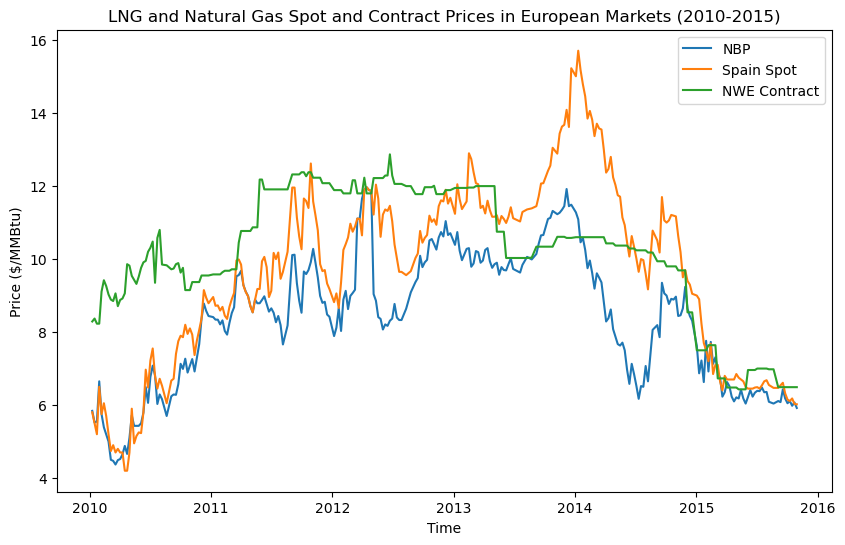

In [153]:
# Display contract and spot prices between 2010 and 2015 to see how spot prices fared against contract prices

# Set the figure size
plt.figure(figsize=(10, 6))

# I will use custom legend labels to increase the readability of my graph
legend_labels1 = ['NBP', 'Spain Spot', 'NWE Contract']

# Plot all the series in a single graph
# the zip() function helps me to combine two or more lists into a single iterable, 
# where elements from corresponding positions are paired together.
for column, legend_label in zip(['nbp', 'spain_sp', 'nwe_con'], legend_labels1):
    plt.plot(lngdata['Date'], lngdata[column], label=legend_label)

plt.xlabel('Time')
plt.ylabel('Price ($/MMBtu)')
plt.title('LNG and Natural Gas Spot and Contract Prices in European Markets (2010-2015)')
plt.legend()

# Show the plot
plt.show()

Although spot and long-term contract prices intersect a few times, more often than not, there are considerable discrepancies between them. 

It is particularly interesting to see that buyers pay higher prices for LNG for what they purchase under long-term contracts. In fact we notice times when the contract price is twice as high as the spot price. Now let's quantify these arguments and display how much Northwest Europe (German Border) Contract Price has been higher than NBP during this 6-year period.

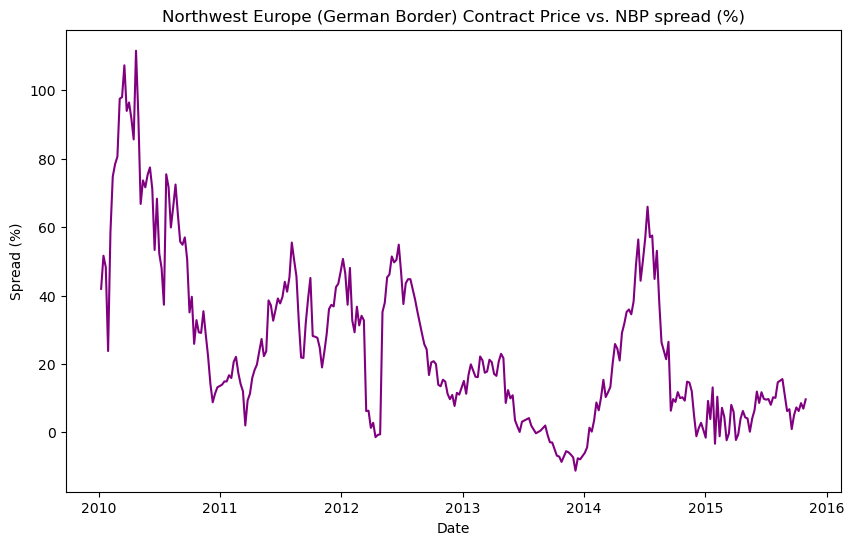

In [154]:
# Display Northwest Europe (German Border) Contract Price vs. NBP spread
lngdata['nwe_nbp_spread'] = (lngdata['nwe_con']/lngdata['nbp'])-1

# To display 'nwe_nbp_spread' in percentage terms, I am multiplying it by 100
lngdata['nwe_nbp_spread_perc'] = lngdata['nwe_nbp_spread'] * 100

# Set the figure size
plt.figure(figsize=(10, 6))

plt.plot(lngdata['Date'], lngdata['nwe_nbp_spread_perc'], color='purple')

# Add labels
plt.xlabel('Date')
plt.ylabel('Spread (%)')
plt.title('Northwest Europe (German Border) Contract Price vs. NBP spread (%)')

plt.show()

In [155]:
avg_nwe_nbp_spread = lngdata['nwe_nbp_spread_perc'].mean()
print(avg_nwe_nbp_spread)

25.140976169877042


On average, NBP was 25% higher than German Border Contract Price (NWE) during 2010-2015 period. Now let's check how Japan LNG contract prices fared versus LNG spot prices.

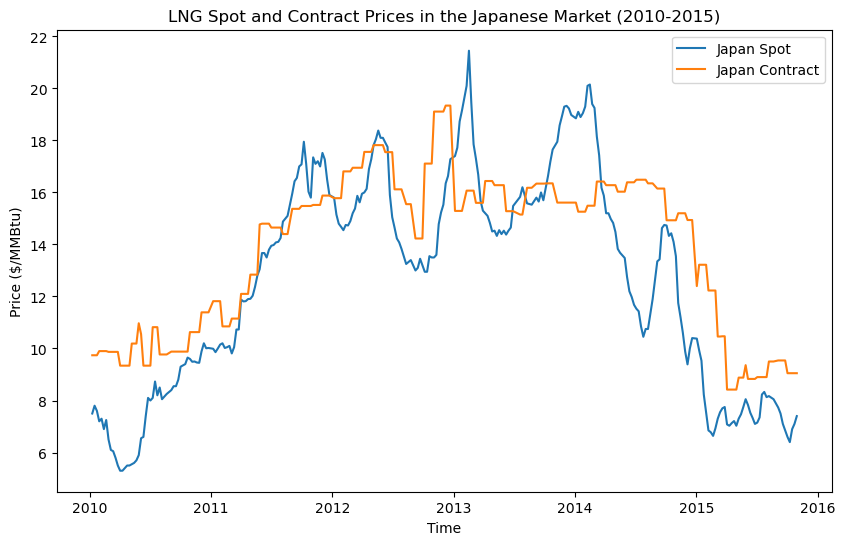

In [156]:
plt.figure(figsize=(10, 6))

# I will use custom legend labels to increase the readability of my graph
legend_labels2 = ['Japan Spot', 'Japan Contract']

# Plot the series in a single graph
for column, legend_label in zip(['japan_sp', 'japan_con'], legend_labels2):
    plt.plot(lngdata['Date'], lngdata[column], label=legend_label)

plt.xlabel('Time')
plt.ylabel('Price ($/MMBtu)')
plt.title('LNG Spot and Contract Prices in the Japanese Market (2010-2015)')
plt.legend()

# Show the plot
plt.show()

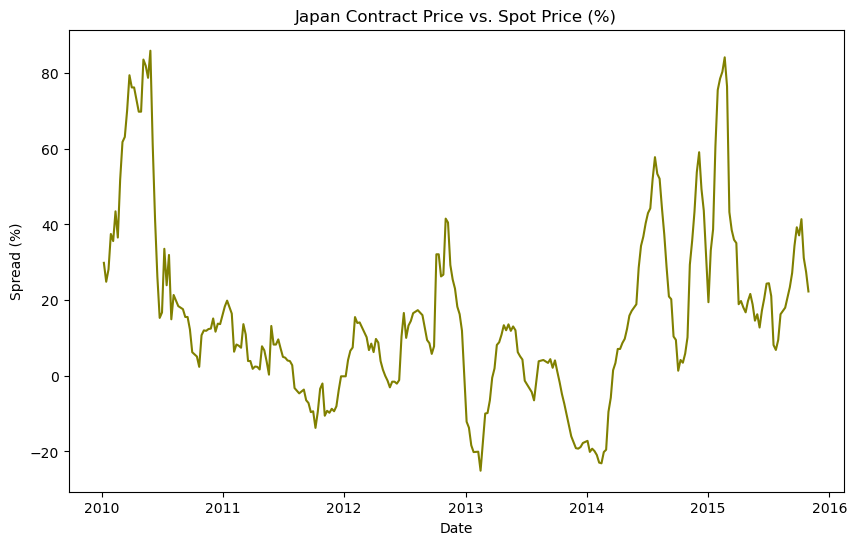

In [157]:
# Display Japan Contract Price vs. Spot Price
lngdata['japan_con_spot_spread'] = (lngdata['japan_con']/lngdata['japan_sp'])-1

# To display 'japan_con_spot_spread' in percentage terms, I am multiplying it by 100
lngdata['japan_con_spot_spread_perc'] = lngdata['japan_con_spot_spread'] * 100

# Set the figure size
plt.figure(figsize=(10, 6))

plt.plot(lngdata['Date'], lngdata['japan_con_spot_spread_perc'], color='olive')

plt.xlabel('Date')
plt.ylabel('Spread (%)')
plt.title('Japan Contract Price vs. Spot Price (%)')

plt.show()

In [158]:
avg_japan_con_spot_spread = lngdata['japan_con_spot_spread_perc'].mean()
print(avg_japan_con_spot_spread)

15.185661388555712


On average, in Japan, LNG contract prices were 15% higher than spot prices during the 2010-2015 period, despite the boosting impact of the Fukushima Nuclear Disaster on spot prices.

Some argue that much of the LNG sold in the Japanese spot market during the time frame I analyze actually originated from vessels initially destined for Northwest Europe or the U.S., but were diverted or re-exported to Japan afterward. Consequently, the higher of the NBP or Henry Hub price effectively served as the floor price for spot and short-term cargoes delivered to the Japanese market. Let's examine whether this argument holds true.

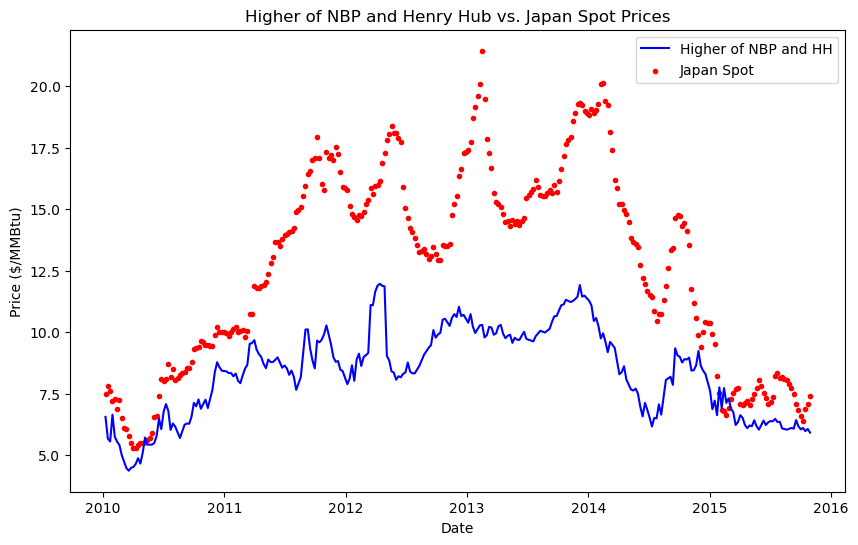

In [159]:
# Create a new column 'higher_nbp_hh' containing the maximum of 'hh' and 'nbp' for each row
lngdata['higher_nbp_hh'] = lngdata[['hh', 'nbp']].max(axis=1)

# Now let's display it against Japan spot prices

plt.figure(figsize=(10, 6))

# Create a line plot for 'higher_hh_nbp' against 'Date'
plt.plot(lngdata['Date'], lngdata['higher_nbp_hh'], label='Higher of NBP and HH', color='blue')

# Create a scatter plot for 'japan_con' against 'Date' with markers
plt.scatter(lngdata['Date'], lngdata['japan_sp'], label='Japan Spot', color='red', marker='.')

# Add labels and a legend
plt.xlabel('Date')
plt.ylabel('Price ($/MMBtu)')
plt.title('Higher of NBP and Henry Hub vs. Japan Spot Prices')
plt.legend()

plt.show()

The graph above illustrates that, for the overwhelming majority of the time, Japan spot prices have exceeded the higher of NBP and Henry Hub. However, I'd like to determine the exact percentage of the time when this is the case and below is the response for it.

In [160]:
# Create a new column 'higher_nbp_hh_higher' with True/False values
lngdata['japan_sp_higher'] = lngdata['japan_sp'] > lngdata['higher_nbp_hh']

# Then calculate the percentage of 'True' values in the 'japan_sp_higher' column
percent_higher = (lngdata['japan_sp_higher'].sum() / len(lngdata)) * 100

print(f"Percentage of time Japan spot prices is higher than High of NBP and Henry Hub is {percent_higher:.2f}%")

Percentage of time Japan spot prices is higher than High of NBP and Henry Hub is 98.03%


<a id='adf'></a>
## Methodology

Unlike classical OLS models, economic time series do not usually display a stationary pattern. Stationarity implies that time series have a constant mean and variance over time, and any shock to the series vanishes without having a lasting impact. Failing to identify appropriate stationarity or unit root behavior of the series might lead one to end up with spurious regressions and deceptive conclusions. 

### Augmented Dickey-Fuller Unit Root Test

In unit root tests, if time series are found to be non-stationary at their level values, they are made stationary either by taking logarithms and/or differencing. The number of times that the differencing operation must take place in order to make nonstationary data stationary is referred as the order of integration. 

A series is called integrated of order 1, or I(1), or difference stationary, if they become stationary after they are differenced only once. As my unit root test results indicate below, commodity prices and charter rates are non-stationary in their levels representation. So I take their log and first difference in order to make them stationary.

In [161]:
from statsmodels.tsa.stattools import adfuller

selected_variables = ['nbp', 'japan_sp', 'spain_sp', 'nwe_con', 'japan_con', 'brent', 'atl_cha', 'pac_cha', 
                      'qin_coal', 'ara_coal', 'sto_rat', 'london_cdd', 'london_hdd', 'barca_cdd', 'barca_hdd', 
                      'tokyo_cdd', 'tokyo_hdd', 'uk_cm', 'japan_cm', 'spain_cm']

# Let's create an empty DataFrame to store the ADF test results
adf_results = pd.DataFrame(columns=['Variable', 'ADF Statistic', 'P-Value', 'Critical Values'])

# Iterate over the selected variables
for variable in selected_variables:
    # Perform the ADF test
    result = adfuller(lngdata[variable], autolag='AIC')
    
    # Add an asterisk to the variable name to identify p-values less than 0.05
    if result[1] < 0.05:
        variable += '*'

    # Store the results in the DataFrame
    adf_results = adf_results.append({'Variable': variable, 'ADF Statistic': result[0], 'P-Value': result[1], 
                                      'Critical Values': result[4]}, ignore_index=True)

# Display the ADF test results
print(adf_results)

       Variable  ADF Statistic       P-Value  \
0           nbp      -2.497600  1.160593e-01   
1      japan_sp      -2.043988  2.676250e-01   
2      spain_sp      -2.073378  2.553533e-01   
3       nwe_con      -0.118075  9.476081e-01   
4     japan_con      -1.279045  6.387037e-01   
5         brent      -0.700038  8.467397e-01   
6       atl_cha      -0.447850  9.017977e-01   
7       pac_cha      -0.458355  8.998902e-01   
8      qin_coal      -0.523703  8.873074e-01   
9      ara_coal      -0.755640  8.318066e-01   
10     sto_rat*      -6.650435  5.137238e-09   
11  london_cdd*      -8.202025  7.188004e-13   
12  london_hdd*      -7.676723  1.541810e-11   
13   barca_cdd*      -6.052219  1.269582e-07   
14   barca_hdd*      -6.355511  2.548677e-08   
15   tokyo_cdd*      -5.507439  2.007058e-06   
16   tokyo_hdd*      -6.510883  1.101198e-08   
17       uk_cm*      -4.209540  6.348235e-04   
18    japan_cm*      -3.675607  4.469642e-03   
19    spain_cm*      -2.972763  3.751749

In unit root tests, if time series are found to be non-stationary at their level values, they are made stationary either by taking logarithms and/or differencing. The number of times that the differencing operation must take place in order to make nonstationary data stationary is referred as the order of integration. A series is called integrated of order 1, or I(1), or difference stationary, if they become stationary after they are differenced only once. 

My unit root test results indicate above that commodity prices and charter rates are non-stationary in their levels representation. So I take their log and first difference in order to make them stationary.

In [162]:
# Variables to process
log_diff_variables = ['nbp', 'japan_sp', 'spain_sp', 'nwe_con', 'japan_con', 'brent', 'atl_cha', 'pac_cha', 
                      'qin_coal', 'ara_coal']

# Create an empty DataFrame to store the ADF test results
adf_results = pd.DataFrame(columns=['Variable', 'ADF Statistic', 'P-Value', 'Critical Values'])

# Iterate over the selected variables
for variable in log_diff_variables:
    # Take the log of the variable
    log_series = np.log(lngdata[variable])
    
    # Calculate the first differences
    diff_series = log_series.diff().dropna()
    
    # Perform the ADF test on the differenced series
    result = adfuller(diff_series, autolag='AIC')
    
    # Format the p-value to display it as a float with three decimal places
    p_value = f'{result[1]:.3f}'
    
    # Add an asterisk to the variable name to identify p-values less than 0.05
    if result[1] < 0.05:
        variable += '*'
    
    # Append the results to the DataFrame
    adf_results = adf_results.append({'Variable': variable, 'ADF Statistic': result[0], 'P-Value': p_value, 
                                      'Critical Values': result[4]}, ignore_index=True)

# Display the ADF test results
print(adf_results)

     Variable  ADF Statistic P-Value  \
0        nbp*      -5.705072   0.000   
1   japan_sp*      -5.180743   0.000   
2   spain_sp*      -9.888725   0.000   
3    nwe_con*      -8.103367   0.000   
4  japan_con*     -16.290865   0.000   
5      brent*     -13.172374   0.000   
6    atl_cha*     -15.271181   0.000   
7    pac_cha*      -7.809464   0.000   
8   qin_coal*      -8.068975   0.000   
9   ara_coal*      -5.760722   0.000   

                                     Critical Values  
0  {'1%': -3.452789844280995, '5%': -2.8714215122...  
1  {'1%': -3.452713099849546, '5%': -2.8713878394...  
2  {'1%': -3.4523371197407404, '5%': -2.871222860...  
3  {'1%': -3.4524113009049935, '5%': -2.871255412...  
4  {'1%': -3.4521902441030963, '5%': -2.871158406...  
5  {'1%': -3.4521902441030963, '5%': -2.871158406...  
6  {'1%': -3.4521902441030963, '5%': -2.871158406...  
7  {'1%': -3.4523371197407404, '5%': -2.871222860...  
8  {'1%': -3.452263435801039, '5%': -2.8711905261...  
9  {'1%':

<a id='egj'></a>
### Engle-Granger and Johansen Cointegration Tests

The existence of cointegration suggests that cointegrated series have stable long run relationship and they move together in the long run. Cointegration tests help us decide which variables to include in the final ECM models.

First, I will conduct Engel-Granger Cointegration Test with pairs and then I will do Johansen Cointegration Test with the relavant series.

In [163]:
from statsmodels.tsa.stattools import coint

selected_pairs = [
    ('nbp', 'nwe_con'),
    ('nbp', 'brent'),
    ('nbp', 'ara_coal'),
    ('nbp', 'atl_cha'),
    ('japan_sp', 'japan_con'),
    ('japan_sp', 'brent'),
    ('japan_sp', 'pac_cha'),
    ('japan_sp', 'qin_coal'),
    ('japan_sp', 'nbp'),
    ('japan_sp', 'brent'),
    ('spain_sp', 'atl_cha'),
    ('spain_sp', 'ara_coal'),
    ('spain_sp', 'nbp')
]

# Create an empty DataFrame to store the cointegration test results
cointegration_results = pd.DataFrame(columns=['Variable 1', 'Variable 2', 'Cointegration Statistic', 'P-Value', 
                                              'Result'])

# Iterate over the selected pairs
for var1, var2 in selected_pairs:
    # Calculate the logarithm of the variables
    log_var1 = np.log(lngdata[var1])
    log_var2 = np.log(lngdata[var2])

    # Perform the Engel-Granger Cointegration Test
    result = coint(log_var1, log_var2)

    # Extract the test statistic and p-value
    coint_statistic = result[0]
    p_value = result[1]

    # Set the significance level for your test
    significance_level = 0.10

    # Determine the test result
    if p_value < significance_level:
        test_result = "Cointegrated (Reject the null hypothesis)"
    else:
        test_result = "Not Cointegrated (Fail to reject the null hypothesis)"

    # Append the results to the DataFrame
    cointegration_results = cointegration_results.append({
        'Variable 1': var1,
        'Variable 2': var2,
        'Cointegration Statistic': coint_statistic,
        'P-Value': p_value,
        'Result': test_result
    }, ignore_index=True)

# Display the cointegration test results
print(cointegration_results)

   Variable 1 Variable 2  Cointegration Statistic   P-Value  \
0         nbp    nwe_con                -2.859100  0.147603   
1         nbp      brent                -4.197698  0.003677   
2         nbp   ara_coal                -2.759222  0.179005   
3         nbp    atl_cha                -4.239468  0.003176   
4    japan_sp  japan_con                -3.853677  0.011479   
5    japan_sp      brent                -3.160638  0.076761   
6    japan_sp    pac_cha                -3.309789  0.053405   
7    japan_sp   qin_coal                -2.219570  0.414296   
8    japan_sp        nbp                -3.618292  0.023253   
9    japan_sp      brent                -3.160638  0.076761   
10   spain_sp    atl_cha                -2.998383  0.110590   
11   spain_sp   ara_coal                -2.712208  0.195219   
12   spain_sp        nbp                -2.655919  0.215832   

                                               Result  
0   Not Cointegrated (Fail to reject the null hypo...  
1    

The results are mostly in line what I attained in my dissertation. The minor differences stem from the fact that I used Engel-Grenger 'Bivariate' Cointegration Test and the coint function tests for no-cointegration of a 'univariate' equation.

Engle-Granger Cointegration Test is used to check for cointegration between two time series. Now I will utilize Johansen Cointegration Test to test cointegration between LNG spot prices and their possible drivers. Johansen Cointegration Test is used when we have more than two time series. It checks for cointegration among all series, not just pairs. 

In [164]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen


data_nwe = lngdata[['nbp', 'nwe_con', 'brent', 'ara_coal', 'atl_cha']]
data_asia = lngdata[['japan_sp', 'japan_con', 'brent', 'qin_coal', 'pac_cha', 'nbp']]
data_swe = lngdata[['spain_sp', 'nbp', 'brent', 'atl_cha']]

# Let's perform the Johansen Cointegration Test for each set
result_nwe = coint_johansen(data_nwe, det_order=0, k_ar_diff=1)
result_asia = coint_johansen(data_asia, det_order=0, k_ar_diff=1)
result_swe = coint_johansen(data_swe, det_order=0, k_ar_diff=1)

# And then print the Trace Statistic, Eigenvalues, and Critical Values for each set
print("Northwest Europe:")
print("Trace Statistic:", result_nwe.lr1)
print("Max Eigenvalue Statistic:", result_nwe.lr2)
print("Eigenvalues:", result_nwe.eig)
print("Critical Values (Trace):", result_nwe.cvt)
print("Critical Values (Max Eigenvalue):", result_nwe.cvm)

print("\nAsia:")
print("Trace Statistic:", result_asia.lr1)
print("Max Eigenvalue Statistic:", result_asia.lr2)
print("Eigenvalues:", result_asia.eig)
print("Critical Values (Trace):", result_asia.cvt)
print("Critical Values (Max Eigenvalue):", result_asia.cvm)

print("\nSouthwest Europe:")
print("Trace Statistic:", result_swe.lr1)
print("Max Eigenvalue Statistic:", result_swe.lr2)
print("Eigenvalues:", result_swe.eig)
print("Critical Values (Trace):", result_swe.cvt)
print("Critical Values (Max Eigenvalue):", result_swe.cvm)

Northwest Europe:
Trace Statistic: [71.54092579 36.46648968 21.52845566  9.75316165  1.5845572 ]
Max Eigenvalue Statistic: [35.07443611 14.93803402 11.77529401  8.16860444  1.5845572 ]
Eigenvalues: [0.10964989 0.04826028 0.03824067 0.02668583 0.00523314]
Critical Values (Trace): [[65.8202 69.8189 77.8202]
 [44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Critical Values (Max Eigenvalue): [[31.2379 33.8777 39.3693]
 [25.1236 27.5858 32.7172]
 [18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]

Asia:
Trace Statistic: [1.17294987e+02 6.55632735e+01 3.50262024e+01 1.57307065e+01
 7.60874727e+00 8.21476898e-02]
Max Eigenvalue Statistic: [51.73171335 30.53707112 19.29549589  8.12195919  7.52659958  0.08214769]
Eigenvalues: [0.15742876 0.09617193 0.06189404 0.02653548 0.02461451 0.00027198]
Critical Values (Trace): [[ 91.109   95.7542 104.9637]
 [ 65.8202  69.8189  77.8202]
 [ 44.4929  47.8545  54.6815]
 

Trace Statistics and Max Eigenvalue Statistics are greater than Critical Values for Northwest Europe and Asia, suggesting the presence of cointegration in the specified sets of variables. For Southwest Europe, there is also evidence of cointegration when the specified number of cointegrating relationships is set to its maximum value. To summarize;

- My cointegration test results suggest that the NBP spot prices are cointegrated with German border contract natural gas and Brent crude oil prices, and Atlantic charter rates. Nonetheless, there is no cointegration between NBP spot prices and ARA coal prices, meaning that spot and coal prices in Northwest Europe do not move together in the long run.

- Likewise, the Japan spot price is cointegrated with Japan LNG contract and Brent crude oil prices, Pacific charter rates as well as NBP spot prices. In parallel with Europe, coal prices are not cointegrated with LNG spot price in Asia either.

- Spain spot prices are cointegrated with Atlantic charter rates, Brent crude oil and NBP spot prices, although the level of cointegration in Spain’s case is relatively weak. In a similar fashion, spot prices are not cointegrated with coal prices in Spain.

One of the first findings of this research is that coal and LNG prices do not have a cointegrating relationship, and therefore do not move together in the long run in any market. Unlike LNG prices’ fluctuations throughout the covered time period, as the graph below displays both Qinhuangdao and ARA coal prices peak in mid-2011 and follow a downward trend later on due to falling demand and soaring production. 

**Reasons of Declining Coal Demand**

- Tighter regulations introduced for coal-fired plants in almost all major economies of the world significantly reduced coal demand.
- U.K.’s carbon price floor policy clearly puts coal in a disadvantageous position against its alternatives.
- Improving energy efficiency and the renewables’ increasing market share also cause coal demand to drop, especially in Europe. 
- The shale gas revolution in the US made natural gas quite cheap and abundant, which led US’ coal demand to drop markedly in the last decade. 

Taking these changing dynamics of coal into account, my finding of a non-cointegrating relation between coal and LNG seems sensible.

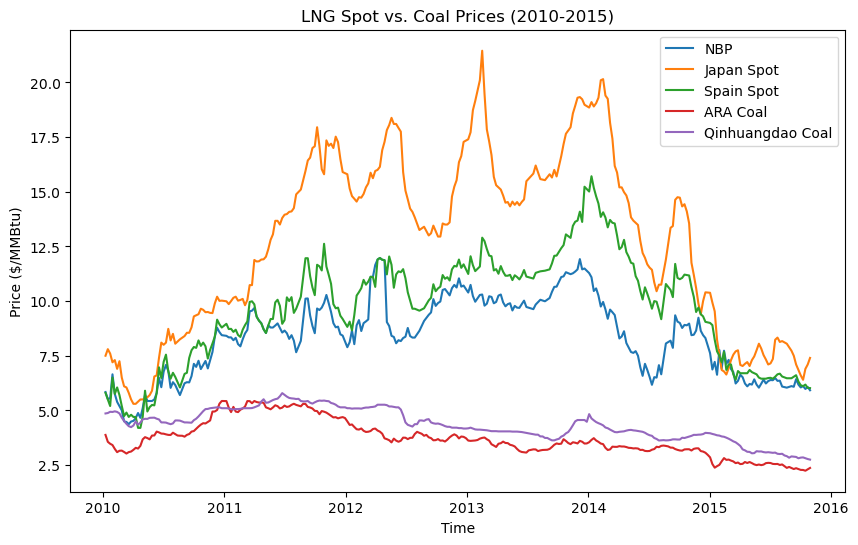

In [165]:
# Display contract and spot prices between 2010 and 2015 to see how spot prices fared against contract prices

# Set the figure size
plt.figure(figsize=(10, 6))

# I will use custom legend labels to increase the readability of my graph
legend_labels3 = ['NBP', 'Japan Spot', 'Spain Spot', 'ARA Coal', 'Qinhuangdao Coal']

# Plot all the series in a single graph
for column, legend_label in zip(['nbp', 'japan_sp', 'spain_sp', 'ara_coal', 'qin_coal'], legend_labels3):
    plt.plot(lngdata['Date'], lngdata[column], label=legend_label)

plt.xlabel('Time')
plt.ylabel('Price ($/MMBtu)')
plt.title('LNG Spot vs. Coal Prices (2010-2015)')
plt.legend()

# Show the plot
plt.show()

<a id='granger'></a>
### Granger Causality Test

After I find that Japan and Spain spot prices are strongly cointegrated with NBP spot prices, I run Granger Causality Tests to make sure that predictive causality in this relation goes from NBP spot prices to Japan and Spain spot prices, and not the other way around. 

It is important to note here that Granger Causality does not necessarily imply causation or prove a direction of influence. That said, it gives an idea about whether one series is helpful to forecast the other series. Granger argues that if the past behaviour of Y can better predict the present behaviour of Z than Z’s past alone, then there might be a type of causality running from Y to Z.

In [166]:
from statsmodels.tsa.stattools import grangercausalitytests

granger_data = lngdata[['nbp', 'japan_sp', 'spain_sp']]

# Specify the maximum lag order for the test
max_lag = 1

# Null Hypothesis: 'nbp' does not Granger cause 'japan_sp'
results1 = grangercausalitytests(granger_data[['japan_sp', 'nbp']], max_lag, verbose=True)

# Null Hypothesis: 'japan_sp' does not Granger cause 'nbp'
results2 = grangercausalitytests(granger_data[['nbp', 'japan_sp']], max_lag, verbose=True)

# Null Hypothesis: 'nbp' does not Granger cause 'spain_sp'
results3 = grangercausalitytests(granger_data[['spain_sp', 'nbp']], max_lag, verbose=True)

# Null Hypothesis: 'spain_sp' does not Granger cause 'nbp'
results4 = grangercausalitytests(granger_data[['nbp', 'spain_sp']], max_lag, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=27.4694 , p=0.0000  , df_denom=300, df_num=1
ssr based chi2 test:   chi2=27.7441 , p=0.0000  , df=1
likelihood ratio test: chi2=26.5465 , p=0.0000  , df=1
parameter F test:         F=27.4694 , p=0.0000  , df_denom=300, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7436  , p=0.3892  , df_denom=300, df_num=1
ssr based chi2 test:   chi2=0.7510  , p=0.3862  , df=1
likelihood ratio test: chi2=0.7501  , p=0.3864  , df=1
parameter F test:         F=0.7436  , p=0.3892  , df_denom=300, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6272  , p=0.0105  , df_denom=300, df_num=1
ssr based chi2 test:   chi2=6.6935  , p=0.0097  , df=1
likelihood ratio test: chi2=6.6206  , p=0.0101  , df=1
parameter F test:         F=6.6272  , p=0.0105  , df_denom=300, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0240  , p=0.8769  

My test results plainly indicate that predictive causality is only in one direction and it is that NBP spot price Granger cause Japan spot and Spain spot prices. Determining the direction of causality is especially essential in order not to misinterpret the final model results.

<a id='ecm'></a>
### Error Correction Model

If the time series are both integrated of the same order and cointegrated, then one can define an error correction model where the changes in the dependent variable is described by the changes both in independent variables and the dependent variable as well as an error correction term. Since the variables in my data set satisfy this requirement, I build an error correction model to describe the relationship between LNG spot price and other commodities along with exogenous variables.

In Error Correction Model, error correction term, $\alpha$, shows the deviations from the long-run cointegration relationship for the cointegrated variables and the absolute value of $\alpha$ indicates how fast equilibrium is restored after that deviation. The error-correction term, $\alpha$, in the ECM must be between 0 and -1. The lagged residuals from the linear regression represent the deviation from the long-run relationship in the previous period. The intuition is if LNG spot price is above its long-run equilibrium, the negative coefficient pulls it back down. If it is below the long-run equilibrium, the negatives will cancel out and become positive pulling the LNG price back up. That is the magic of the ECM.

In my error correction model I can claim causality from LNG contract prices to LNG spot prices if the coefficients of the error correction term and contract price are jointly significant. In such kind of case, a shock that drives the spot price out of its long term relationship from contract prices can be corrected at a weekly rate of $\alpha$, meaning that the spot price adjusts $\alpha$ % weekly to return to its long run relationship with contract prices. The sign and significance of the coefficients of the cointegrated and exogenous variables, on the other hand, tell us about the short term dynamics impacting spot prices.

#### NBP Error Correction Model Estimation Results

In [199]:
# Model 1
nbp_ecm1 = lngdata[['nbp', 'nwe_con']]

# Calculate the logs of the variables
nbp_ecm1['nbp_log'] = np.log(nbp_ecm1['nbp'])
nbp_ecm1['nwe_con_log'] = np.log(nbp_ecm1['nwe_con'])

# Calculate the first differences of the logs
nbp_ecm1['nbp_diff'] = nbp_ecm1['nbp_log'].diff()
nbp_ecm1['nwe_con_diff'] = nbp_ecm1['nwe_con_log'].diff()

# Drop rows with missing or infinite values
nbp_ecm1 = nbp_ecm1.dropna().replace([np.inf, -np.inf], np.nan).dropna()

# Independent variables include nwe_con_log and a constant
independent_variables1 = sm.add_constant(nbp_ecm1['nwe_con_log'])

# Create the ECM model
model = sm.OLS(nbp_ecm1['nbp_log'], independent_variables1)
results = model.fit()

# Get the residuals from the model
residuals = results.resid

# Drop the first row to have the same number of observations as residuals.shift(lag)
nbp_ecm1 = nbp_ecm1.iloc[1:]

# Independent variables include nwe_con_diff, residuals_lagged, and a constant
independent_variables2 = sm.add_constant(pd.concat([nbp_ecm1['nwe_con_diff'], residuals.shift(1).iloc[1:]], axis=1))

# Fit the error correction model
ecm_model = sm.OLS(nbp_ecm1['nbp_diff'], independent_variables2)
ecm_results = ecm_model.fit()

# Print the summary of the ECM
print(ecm_results.summary())

                            OLS Regression Results                            
Dep. Variable:               nbp_diff   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     5.621
Date:                Sun, 05 Nov 2023   Prob (F-statistic):            0.00401
Time:                        12:48:35   Log-Likelihood:                 489.39
No. Observations:                 302   AIC:                            -972.8
Df Residuals:                     299   BIC:                            -961.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0001      0.003      0.048   

The error correction term, $\alpha$ or 0 as displayed in Model 1, -0.0494, satisfies the requirements of being negative and between 0 and -1, and it is significant. This estimate suggests that if NBP spot and German border contract gas prices deviate from their long-run relationship, the NBP spot price will adjust itself to return to the long run equilibrium at the rate of 4.9% a week. 

Yet the fact that the coefficient of German border contract price is insignificant prevents us from claiming that causality is from German border contract gas prices to NBP spot prices. In other words, estimation results of Model 1 confirm that NBP spot and German border contract gas prices move together in the long run and if a shock occurs error correction term corrects the disequilibrium at a speed of 4.9% a week. Still, the test result does not argue that German border contract gas prices impacts NBP LNG spot prices in any way. To put it another way, the model indicates correlation but not causation between NBP spot and German border contract gas prices.

In [205]:
# Model 2
nbp_ecm2 = lngdata[['nbp', 'nwe_con', 'brent', 'atl_cha']]

# Calculate the logs of the variables
nbp_ecm2['nbp_log'] = np.log(nbp_ecm2['nbp'])
nbp_ecm2['nwe_con_log'] = np.log(nbp_ecm2['nwe_con'])
nbp_ecm2['brent_log'] = np.log(nbp_ecm2['brent'])
nbp_ecm2['atl_cha_log'] = np.log(nbp_ecm2['atl_cha'])

# Calculate the first differences of the logs
nbp_ecm2['nbp_diff'] = nbp_ecm2['nbp_log'].diff()
nbp_ecm2['nwe_con_diff'] = nbp_ecm2['nwe_con_log'].diff()
nbp_ecm2['brent_diff'] = nbp_ecm2['brent_log'].diff()
nbp_ecm2['atl_cha_diff'] = nbp_ecm2['atl_cha_log'].diff()

# Drop rows with missing or infinite values
nbp_ecm2 = nbp_ecm2.dropna().replace([np.inf, -np.inf], np.nan).dropna()

# Independent variables include nwe_con_log, brent_log, atl_cha_log, and a constant
independent_variables1 = sm.add_constant(nbp_ecm2[['nwe_con_log', 'brent_log', 'atl_cha_log']])

# Create the ECM model
model = sm.OLS(nbp_ecm2['nbp_log'], independent_variables1)
results = model.fit()

# Get the residuals from the model
residuals = results.resid

# Drop the first row to have the same number of observations as residuals.shift(lag)
nbp_ecm2 = nbp_ecm2.iloc[1:]

# Independent variables include nwe_con_diff, brent_diff, atl_cha_diff, residuals_lagged, and a constant
independent_variables2 = sm.add_constant(pd.concat([nbp_ecm2[['nwe_con_diff', 'brent_diff', 'atl_cha_diff']], 
                                                    residuals.shift(1).iloc[1:]], axis=1))

# Fit the error correction model
ecm_model = sm.OLS(nbp_ecm2['nbp_diff'], independent_variables2)
ecm_results = ecm_model.fit()

# Print the summary of the ECM
print(ecm_results.summary())

                            OLS Regression Results                            
Dep. Variable:               nbp_diff   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     4.941
Date:                Sun, 05 Nov 2023   Prob (F-statistic):           0.000719
Time:                        12:56:09   Log-Likelihood:                 493.54
No. Observations:                 302   AIC:                            -977.1
Df Residuals:                     297   BIC:                            -958.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0006      0.003      0.212   

In the second model, I run the NBP spot price over all cointegrated variables; namely German border contract gas price, Brent, and Atlantic charter rates. Adding other cointegrated variables to the model almost doubles the error correction term to -0.0869 while keeping it significant at the 1% level. This coefficient affirms NBP spot price’s long- term relationship with these cointegrated variables and shows that if a shock occurs the NBP spot price will return to its long-term equilibrium at the rate of 8.69% a week. 

The Brent crude oil price has the only significant coefficient among all short run coefficients. Its significance implies that oil prices do have a positive causal effect on NBP spot prices in the short run, that is to say an increase in oil prices will lead to an increase in NBP spot prices.

In [206]:
# Model 3
nbp_ecm3 = lngdata[['nbp', 'nwe_con', 'brent', 'atl_cha', 'sto_rat', 'london_cdd', 'london_hdd', 'uk_ip' ]]

# Calculate the logs of the variables
nbp_ecm3['nbp_log'] = np.log(nbp_ecm3['nbp'])
nbp_ecm3['nwe_con_log'] = np.log(nbp_ecm3['nwe_con'])
nbp_ecm3['brent_log'] = np.log(nbp_ecm3['brent'])
nbp_ecm3['atl_cha_log'] = np.log(nbp_ecm3['atl_cha'])

# Calculate the first differences of the logs
nbp_ecm3['nbp_diff'] = nbp_ecm3['nbp_log'].diff()
nbp_ecm3['nwe_con_diff'] = nbp_ecm3['nwe_con_log'].diff()
nbp_ecm3['brent_diff'] = nbp_ecm3['brent_log'].diff()
nbp_ecm3['atl_cha_diff'] = nbp_ecm3['atl_cha_log'].diff()

# Drop rows with missing or infinite values
nbp_ecm3 = nbp_ecm3.dropna().replace([np.inf, -np.inf], np.nan).dropna()

# Independent variables include nwe_con_log, brent_log, atl_cha_log, sto_rat, london_cdd, london_hdd, uk_ip, and a constant
independent_variables1 = sm.add_constant(nbp_ecm3[['nwe_con_log', 'brent_log', 'atl_cha_log', 'sto_rat', 
                                                   'london_cdd', 'london_hdd', 'uk_ip']])

# Create the ECM model
model = sm.OLS(nbp_ecm3['nbp_log'], independent_variables1)
results = model.fit()

# Get the residuals from the model
residuals = results.resid

# Drop the first row to have the same number of observations as residuals.shift(lag)
nbp_ecm3 = nbp_ecm3.iloc[1:]

# Independent variables include nwe_con_diff, brent_diff, atl_cha_diff, sto_rat, london_cdd, london_hdd, uk_ip, residuals_lagged, and a constant
independent_variables2 = sm.add_constant(pd.concat([nbp_ecm3[['nwe_con_diff', 'brent_diff', 'atl_cha_diff', 
                        'sto_rat', 'london_cdd', 'london_hdd', 'uk_ip']], residuals.shift(1).iloc[1:]], axis=1))

# Fit the error correction model
ecm_model = sm.OLS(nbp_ecm3['nbp_diff'], independent_variables2)
ecm_results = ecm_model.fit()

# Print the summary of the ECM
print(ecm_results.summary())

                            OLS Regression Results                            
Dep. Variable:               nbp_diff   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     3.298
Date:                Sun, 05 Nov 2023   Prob (F-statistic):            0.00127
Time:                        16:11:27   Log-Likelihood:                 496.84
No. Observations:                 302   AIC:                            -975.7
Df Residuals:                     293   BIC:                            -942.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0944      0.076     -1.242   

I run the third model with cointegrated and exogenous variables. Nevertheless, none of the exogenous variables are significant, except for oil prices. Therefore, I conclude that while NBP spot prices have a long-term relationship with German border contract gas and Brent crude oil prices, and Atlantic charter rates; only oil prices affect NBP spot prices in the short run.

#### Japan Spot Error Correction Model Estimation Results

In [207]:
# Model 1
japan_ecm1 = lngdata[['japan_sp', 'japan_con']]

# Calculate the logs of the variables
japan_ecm1['japan_sp_log'] = np.log(japan_ecm1['japan_sp'])
japan_ecm1['japan_con_log'] = np.log(japan_ecm1['japan_con'])

# Calculate the first differences of the logs
japan_ecm1['japan_sp_diff'] = japan_ecm1['japan_sp_log'].diff()
japan_ecm1['japan_con_diff'] = japan_ecm1['japan_con_log'].diff()

# Drop rows with missing or infinite values
japan_ecm1 = japan_ecm1.dropna().replace([np.inf, -np.inf], np.nan).dropna()

# Independent variables include nwe_con_log and a constant
independent_variables1 = sm.add_constant(japan_ecm1['japan_con_log'])

# Create the ECM model
model = sm.OLS(japan_ecm1['japan_sp_log'], independent_variables1)
results = model.fit()

# Get the residuals from the model
residuals = results.resid

# Drop the first row to have the same number of observations as residuals.shift(lag)
japan_ecm1 = japan_ecm1.iloc[1:]

# Independent variables include japan_con_diff, residuals_lagged, and a constant
independent_variables2 = sm.add_constant(pd.concat([japan_ecm1['japan_con_diff'], residuals.shift(1).iloc[1:]], 
                                                   axis=1))

# Fit the error correction model
ecm_model = sm.OLS(japan_ecm1['japan_sp_diff'], independent_variables2)
ecm_results = ecm_model.fit()

# Print the summary of the ECM
print(ecm_results.summary())

                            OLS Regression Results                            
Dep. Variable:          japan_sp_diff   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.218
Date:                Sun, 05 Nov 2023   Prob (F-statistic):              0.297
Time:                        16:32:52   Log-Likelihood:                 566.11
No. Observations:                 302   AIC:                            -1126.
Df Residuals:                     299   BIC:                            -1115.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0002      0.002     -0.

In the first error correction model for Japan, the error correction term does not appear significant when the spot price is regressed on contract prices. This result does not negate the cointegration between spot and contract LNG price in Japan that I have found in Engle-Granger cointegration test. It does indicate, however, that the Japan spot price does not adjust and return to the equilibrium if spot and contract prices shift away from their long term relationship.

In [212]:
# Model 2
japan_ecm2 = lngdata[['japan_sp', 'japan_con', 'brent', 'pac_cha', 'nbp']]

# Calculate the logs of the variables
japan_ecm2['japan_sp_log'] = np.log(japan_ecm2['japan_sp'])
japan_ecm2['japan_con_log'] = np.log(japan_ecm2['japan_con'])
japan_ecm2['brent_log'] = np.log(japan_ecm2['brent'])
japan_ecm2['pac_cha_log'] = np.log(japan_ecm2['pac_cha'])
japan_ecm2['nbp_log'] = np.log(japan_ecm2['nbp'])

# Calculate the first differences of the logs
japan_ecm2['japan_sp_diff'] = japan_ecm2['japan_sp_log'].diff()
japan_ecm2['japan_con_diff'] = japan_ecm2['japan_con_log'].diff()
japan_ecm2['brent_diff'] = japan_ecm2['brent_log'].diff()
japan_ecm2['pac_cha_diff'] = japan_ecm2['pac_cha_log'].diff()
japan_ecm2['nbp_diff'] = japan_ecm2['nbp_log'].diff()

# Drop rows with missing or infinite values
japan_ecm2 = japan_ecm2.dropna().replace([np.inf, -np.inf], np.nan).dropna()

# Independent variables include japan_con_log, brent_log, pac_cha_log, nbp_log, and a constant
independent_variables1 = sm.add_constant(japan_ecm2[['japan_con_log', 'brent_log', 'pac_cha_log', 'nbp_log']])

# Create the ECM model
model = sm.OLS(japan_ecm2['japan_sp_log'], independent_variables1)
results = model.fit()

# Get the residuals from the model
residuals = results.resid

# Drop the first row to have the same number of observations as residuals.shift(lag)
japan_ecm2 = japan_ecm2.iloc[1:]

# Independent variables include japan_con_diff, brent_diff, pac_cha_diff, nbp_diff, residuals_lagged, and a constant
independent_variables2 = sm.add_constant(pd.concat([japan_ecm2[['japan_con_diff', 'brent_diff', 'pac_cha_diff', 
                                                    'nbp_diff']], residuals.shift(1).iloc[1:]], axis=1))

# Fit the error correction model
ecm_model = sm.OLS(japan_ecm2['japan_sp_diff'], independent_variables2)
ecm_results = ecm_model.fit()

# Print the summary of the ECM
print(ecm_results.summary())

                            OLS Regression Results                            
Dep. Variable:          japan_sp_diff   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     8.132
Date:                Sun, 05 Nov 2023   Prob (F-statistic):           3.30e-07
Time:                        17:09:36   Log-Likelihood:                 584.32
No. Observations:                 302   AIC:                            -1157.
Df Residuals:                     296   BIC:                            -1134.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0002      0.002      0.

When I add other cointegrated variables, Brent, NBP, and Pacific charter rate, into the second model, I find that the cointegrating term and coefficients of Pacific charter rate and the NBP are significant. This result suggests that Japan spot prices are in a long-term equilibrium with Japan contract, Brent crude oil, and NBP spot prices, and Pacific charter, and it corrects itself at a rate of 7.5% a week to return to their long term equilibrium if a shock occurs. Positive and significant coefficients of Pacific charter rate and the NBP imply that an increase in Pacific charter rate and NBP will bring about an increase in Japan LNG spot prices in the short run.

In [214]:
# Model 3
japan_ecm3 = lngdata[['japan_sp', 'japan_con', 'brent', 'pac_cha', 'nbp', 'tokyo_cdd', 'tokyo_hdd', 'japan_ip']]

# Calculate the logs of the variables
japan_ecm3['japan_sp_log'] = np.log(japan_ecm3['japan_sp'])
japan_ecm3['japan_con_log'] = np.log(japan_ecm3['japan_con'])
japan_ecm3['brent_log'] = np.log(japan_ecm3['brent'])
japan_ecm3['pac_cha_log'] = np.log(japan_ecm3['pac_cha'])
japan_ecm3['nbp_log'] = np.log(japan_ecm3['nbp'])

# Calculate the first differences of the logs
japan_ecm3['japan_sp_diff'] = japan_ecm3['japan_sp_log'].diff()
japan_ecm3['japan_con_diff'] = japan_ecm3['japan_con_log'].diff()
japan_ecm3['brent_diff'] = japan_ecm3['brent_log'].diff()
japan_ecm3['pac_cha_diff'] = japan_ecm3['pac_cha_log'].diff()
japan_ecm3['nbp_diff'] = japan_ecm3['nbp_log'].diff()

# Drop rows with missing or infinite values
japan_ecm3 = japan_ecm3.dropna().replace([np.inf, -np.inf], np.nan).dropna()

# Independent variables include japan_con_log, brent_log, pac_cha_log, nbp_log, and a constant
independent_variables1 = sm.add_constant(japan_ecm3[['japan_con_log', 'brent_log', 'pac_cha_log', 'nbp_log']])

# Create the ECM model
model = sm.OLS(japan_ecm3['japan_sp_log'], independent_variables1)
results = model.fit()

# Get the residuals from the model
residuals = results.resid

# Drop the first row to have the same number of observations as residuals.shift(lag)
japan_ecm3 = japan_ecm3.iloc[1:]

# Independent variables include japan_con_diff, brent_diff, pac_cha_diff, nbp_diff, residuals_lagged, and a constant
independent_variables2 = sm.add_constant(pd.concat([japan_ecm3[['japan_con_diff', 'brent_diff', 'pac_cha_diff', 
                        'nbp_diff', 'tokyo_cdd', 'tokyo_hdd', 'japan_ip']], residuals.shift(1).iloc[1:]], axis=1))

# Fit the error correction model
ecm_model = sm.OLS(japan_ecm3['japan_sp_diff'], independent_variables2)
ecm_results = ecm_model.fit()

# Print the summary of the ECM
print(ecm_results.summary())

                            OLS Regression Results                            
Dep. Variable:          japan_sp_diff   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     5.673
Date:                Sun, 05 Nov 2023   Prob (F-statistic):           1.04e-06
Time:                        17:21:50   Log-Likelihood:                 586.63
No. Observations:                 302   AIC:                            -1155.
Df Residuals:                     293   BIC:                            -1122.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0438      0.044      0.

The addition of exogenous variables in the third model did not change the coefficients of cointegrated variables much. In conclusion, the Japan error correction model tells us that Japan spot prices have a long term relationship with Japan contract, Brent crude oil, and NBP spot prices, and Pacific charter rate and but only Pacific charter rate, and NBP spot prices have positive causal impact on Japan spot prices.

#### Spain Spot Error Correction Model Estimation Results

In [216]:
# Model 1
spain_ecm1 = lngdata[['spain_sp', 'brent', 'atl_cha', 'nbp']]

# Calculate the logs of the variables
spain_ecm1['spain_sp_log'] = np.log(spain_ecm1['spain_sp'])
spain_ecm1['brent_log'] = np.log(spain_ecm1['brent'])
spain_ecm1['atl_cha_log'] = np.log(spain_ecm1['atl_cha'])
spain_ecm1['nbp_log'] = np.log(spain_ecm1['nbp'])

# Calculate the first differences of the logs
spain_ecm1['spain_sp_diff'] = spain_ecm1['spain_sp_log'].diff()
spain_ecm1['brent_diff'] = spain_ecm1['brent_log'].diff()
spain_ecm1['atl_cha_diff'] = spain_ecm1['atl_cha_log'].diff()
spain_ecm1['nbp_diff'] = spain_ecm1['nbp_log'].diff()

# Drop rows with missing or infinite values
spain_ecm1 = spain_ecm1.dropna().replace([np.inf, -np.inf], np.nan).dropna()

# Independent variables include brent_log, atl_cha_log, nbp_log, and a constant
independent_variables1 = sm.add_constant(spain_ecm1[['brent_log', 'atl_cha_log', 'nbp_log']])

# Create the ECM model
model = sm.OLS(spain_ecm1['spain_sp_log'], independent_variables1)
results = model.fit()

# Get the residuals from the model
residuals = results.resid

# Drop the first row to have the same number of observations as residuals.shift(lag)
spain_ecm1 = spain_ecm1.iloc[1:]

# Independent variables include japan_con_diff, residuals_lagged, and a constant
independent_variables2 = sm.add_constant(pd.concat([spain_ecm1[['brent_diff', 'atl_cha_diff', 'nbp_diff']], 
                                                    residuals.shift(1).iloc[1:]], axis=1))

# Fit the error correction model
ecm_model = sm.OLS(spain_ecm1['spain_sp_diff'], independent_variables2)
ecm_results = ecm_model.fit()

# Print the summary of the ECM
print(ecm_results.summary())

                            OLS Regression Results                            
Dep. Variable:          spain_sp_diff   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     52.63
Date:                Sun, 05 Nov 2023   Prob (F-statistic):           1.74e-33
Time:                        17:33:55   Log-Likelihood:                 566.98
No. Observations:                 302   AIC:                            -1124.
Df Residuals:                     297   BIC:                            -1105.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         6.466e-05      0.002      0.030   

In [217]:
# Model 2
spain_ecm2 = lngdata[['spain_sp', 'brent', 'atl_cha', 'nbp', 'barca_cdd', 'barca_hdd', 'spain_ip']]

# Calculate the logs of the variables
spain_ecm2['spain_sp_log'] = np.log(spain_ecm2['spain_sp'])
spain_ecm2['brent_log'] = np.log(spain_ecm2['brent'])
spain_ecm2['atl_cha_log'] = np.log(spain_ecm2['atl_cha'])
spain_ecm2['nbp_log'] = np.log(spain_ecm2['nbp'])

# Calculate the first differences of the logs
spain_ecm2['spain_sp_diff'] = spain_ecm2['spain_sp_log'].diff()
spain_ecm2['brent_diff'] = spain_ecm2['brent_log'].diff()
spain_ecm2['atl_cha_diff'] = spain_ecm2['atl_cha_log'].diff()
spain_ecm2['nbp_diff'] = spain_ecm2['nbp_log'].diff()

# Drop rows with missing or infinite values
spain_ecm2 = spain_ecm2.dropna().replace([np.inf, -np.inf], np.nan).dropna()

# Independent variables include brent_log, atl_cha_log, nbp_log, and a constant
independent_variables1 = sm.add_constant(spain_ecm2[['brent_log', 'atl_cha_log', 'nbp_log']])

# Create the ECM model
model = sm.OLS(spain_ecm2['spain_sp_log'], independent_variables1)
results = model.fit()

# Get the residuals from the model
residuals = results.resid

# Drop the first row to have the same number of observations as residuals.shift(lag)
spain_ecm2 = spain_ecm2.iloc[1:]

# Independent variables include japan_con_diff, residuals_lagged, and a constant
independent_variables2 = sm.add_constant(pd.concat([spain_ecm2[['brent_diff', 'atl_cha_diff', 'nbp_diff', 
                        'barca_cdd', 'barca_hdd', 'spain_ip']], residuals.shift(1).iloc[1:]], axis=1))

# Fit the error correction model
ecm_model = sm.OLS(spain_ecm2['spain_sp_diff'], independent_variables2)
ecm_results = ecm_model.fit()

# Print the summary of the ECM
print(ecm_results.summary())

                            OLS Regression Results                            
Dep. Variable:          spain_sp_diff   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     29.98
Date:                Sun, 05 Nov 2023   Prob (F-statistic):           3.79e-31
Time:                        17:40:54   Log-Likelihood:                 567.41
No. Observations:                 302   AIC:                            -1119.
Df Residuals:                     294   BIC:                            -1089.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0230      0.031      0.743   

In the third specification, I have run the Spain spot price with its cointegrated and exogenous variables as there is no contract price data available for Spain. In both models the error correction term and the coefficient of the NBP is significant at 1% level, signaling a strong long run relationship and short run causality. These results also prove that Spanish LNG spot prices are tightly connected to continental European LNG prices.

The findings additionally imply that Spain spot prices have a long term equilibrium with Brent crude oil prices and the Atlantic charter rate. More specifically, if Spain spot, crude oil, NBP, and charter rate move away from their long-run relationship, Spain spot prices adjusts to return to the equilibrium at a rate of 8.5% per week. According to the estimation results, however, neither the temperature variables, nor industrial production indices have an influence on Spain spot prices in the short run.

<a id='results'></a>
### Conclusion

- In this study, I conducted a comprehensive analysis of global LNG spot prices, aiming to identify the driving forces behind these markets. The research unveiled some valuable insights that shed light on the dynamics of LNG pricing.

- The empirical findings strongly indicate that LNG spot prices in Japan and Spain were significantly influenced by the NBP natural gas prices, reinforcing the interconnectivity of global natural gas markets. Most notably, the NBP spot prices were observed to be driven by crude oil prices, suggesting that, despite advancements in deregulation within the European gas markets, the traditional relationship between oil and LNG prices remains steadfast.

- However, it's crucial to recognize the broader context in which energy markets operate. Geopolitical factors, sometimes intentionally or unintentionally, exert an undeniable influence on energy prices. Recent events, such as Russia's invasion of Ukraine, serve as a stark reminder of the susceptibility of energy markets to geopolitical tensions.

- In terms of the broader implications of this study, these findings are of particular relevance to businesses operating in the LNG sector. Understanding the persisting link between oil and LNG prices is essential for risk management and pricing strategies. As the LNG market continues to evolve, market participants must remain vigilant about the ever-present influence of oil prices.

- In a personal capacity, this research endeavor has significantly enhanced my quantitative modeling skills. I am profoundly grateful for the opportunity to engage in this work and for the support and guidance I have received throughout this research journey. These newly acquired skills will undoubtedly contribute to my professional growth, enabling me to make meaningful impacts in my future endeavors within the energy industry.